In [3]:
# PI Controller with LinearRegression

import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression

df = pd.read_csv(
    "C:\\Users\\90545\\OneDrive\\Masaüstü\\LESSONS\\BITIRMEPROJESI\\ankara_temperature_2025.csv",
    parse_dates=["Timestamp"]
)
df = df.set_index("Timestamp").sort_index()

TARGET_TEMP = 20.0
Kp = 0.6
Ki = 0.05
Ke = 0.1
MAX_CONTROL = 6.7
MIN_CONTROL = -6.7

indoor_temp = None
integral_error = 0.0
previous_time = None
results = []

for ts in df.index:
    outdoor_temp = df.at[ts, "Temperature (°C)"]

    if indoor_temp is None:
        indoor_temp = outdoor_temp

    # İlk 4 gün boyunca sadece dış ortamın etkisini uygula
    if ts - df.index[0] < timedelta(days=4):
        influence_from_outdoor = 0.06 * (outdoor_temp - indoor_temp)
        predicted_temp = indoor_temp + influence_from_outdoor
        indoor_temp = predicted_temp

        results.append({
            "Timestamp": ts,
            "Outdoor Temp (°C)": outdoor_temp,
            "Indoor Temp (°C)": indoor_temp,
            "Predicted Temp (°C)": predicted_temp,
            "Control Output": 0.0
        })
        continue

    # Sadece son 4 indoor sıcaklığı ile lineer regresyon yap
    recent_indoor_temps = [r["Indoor Temp (°C)"] for r in results[-4:]]
    if len(recent_indoor_temps) < 4:
        continue

    x = np.array(range(4)).reshape(-1, 1)
    y = np.array(recent_indoor_temps).reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    predicted_temp = model.predict([[4]]).item()

    error = TARGET_TEMP - predicted_temp
    external_effect = outdoor_temp - TARGET_TEMP

    if previous_time is not None:
        delta_t = (ts - previous_time).total_seconds() / 60
    else:
        delta_t = 1
    previous_time = ts

    integral_error += error * delta_t
    integral_error = max(min(integral_error, 100), -100)

    control_output = (
        Kp * error
        - Ke * external_effect
        + Ki * integral_error
    )
    control_output = max(min(control_output, MAX_CONTROL), MIN_CONTROL)

    influence_from_outdoor = 0.06 * (outdoor_temp - indoor_temp)
    influence_from_ac = 0.2 * control_output
    indoor_temp = indoor_temp + influence_from_outdoor + influence_from_ac

    results.append({
        "Timestamp": ts,
        "Outdoor Temp (°C)": outdoor_temp,
        "Indoor Temp (°C)": indoor_temp,
        "Predicted Temp (°C)": predicted_temp,
        "Control Output": control_output
    })

res_df = pd.DataFrame(results).set_index("Timestamp")

# 5 saatlik 100 kesit
np.random.seed(42)
valid_slices = []
attempts = 0
needed_slices = 100
available_indices = range(len(res_df) - 5)

while len(valid_slices) < needed_slices and attempts < 5000:
    attempts += 1
    random_pos = np.random.choice(available_indices)
    slice_df = res_df.iloc[random_pos:random_pos + 5]

    if len(slice_df) == 5:
        valid_slices.append(slice_df)

samples_df = pd.concat(valid_slices, keys=range(1, needed_slices + 1))

for i in range(1, needed_slices + 1):
    print(f"--- Kesit {i} ---")
    print(samples_df.loc[i])
    print("\n")

print(f"Toplam kesit sayısı: {len(valid_slices)}")
print(f"Toplam satır sayısı: {len(samples_df)}")


--- Kesit 1 ---
                     Outdoor Temp (°C)  Indoor Temp (°C)  Predicted Temp (°C)  \
Timestamp                                                                       
2025-06-14 12:45:00          32.209254         20.008408            19.972680   
2025-06-14 13:00:00          30.453633         19.983400            19.969954   
2025-06-14 13:15:00          30.661797         19.972729            19.969942   
2025-06-14 13:30:00          31.542666         19.999266            19.981705   
2025-06-14 13:45:00          30.718404         19.994059            19.981426   

                     Control Output  
Timestamp                            
2025-06-14 12:45:00       -3.458340  
2025-06-14 13:00:00       -3.258608  
2025-06-14 13:15:00       -3.256874  
2025-06-14 13:30:00       -3.338298  
2025-06-14 13:45:00       -3.241774  


--- Kesit 2 ---
                     Outdoor Temp (°C)  Indoor Temp (°C)  Predicted Temp (°C)  \
Timestamp                                          

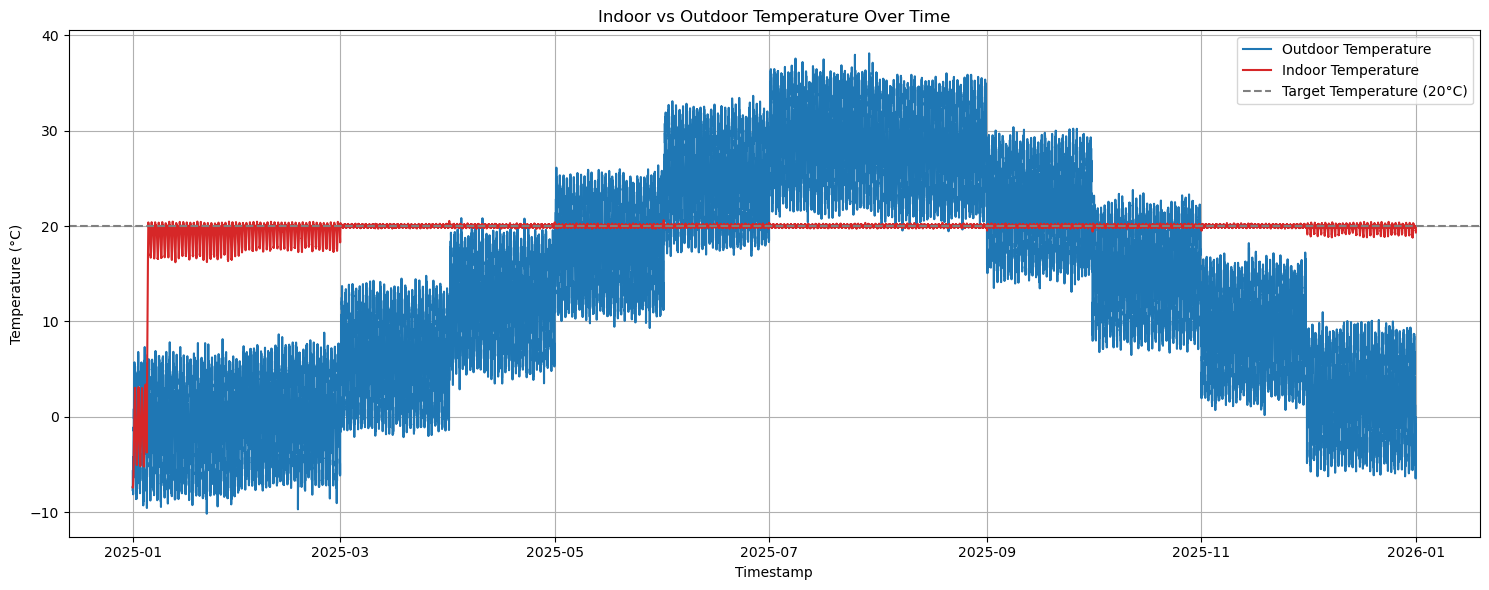

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(res_df.index, res_df["Outdoor Temp (°C)"], label="Outdoor Temperature", color="tab:blue")
plt.plot(res_df.index, res_df["Indoor Temp (°C)"], label="Indoor Temperature", color="tab:red")
plt.axhline(y=TARGET_TEMP, color="gray", linestyle="--", label="Target Temperature (20°C)")

plt.title("Indoor vs Outdoor Temperature Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
